In [48]:
# To render the plot
%matplotlib inline

In [49]:
import os
import mne
import numpy as np
import matplotlib

# Preprocessing
The steps in EEG preprocessing:

* Highpass filter
* Lowpass filter
* Artefact rejection
    * Ocular artifacts (EOG)
    * Heartbeat artifacts (ECG)
    * Power line noise
    * Methods:
        * Thresholding
        * ICA
* (Rereference)
* Epoching
* Evokeds (i.e. averaging)


In [50]:
# Define path to the raw data (.fif-file)
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')

In [51]:
# Read in raw data -> preload = True, to load into memory (needed for filtering)
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)

Opening raw data file C:\Users\Lenovo\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


In [52]:
# Pick type of data you want. stim = True, to include stimulus onsets (and to calculate epochs)
raw.pick_types(meg=False, eeg=True, stim=True)

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


<Raw | sample_audvis_filt-0-40_raw.fif, 68 x 41700 (277.7 s), ~24.6 MB, data loaded>

In [53]:
#Check to see if data is filtered:
raw.info

<Info | 14 non-empty values
 bads: []
 ch_names: STI 001, STI 002, STI 003, STI 004, STI 005, STI 006, STI 014, ...
 chs: 9 STIM, 59 EEG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 68
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>

In [54]:
# Filter the data - do it in two steps (if it isn't already):

#           raw = raw.copy().filter(None, 40.)
#           raw.filter(0.1, None)


# first argument is the high-pass filter, second is low-pass filter
# remember to do it to a copy of the data

Effective window size : 10.003 (s)


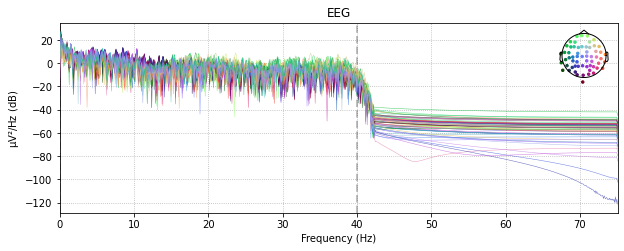

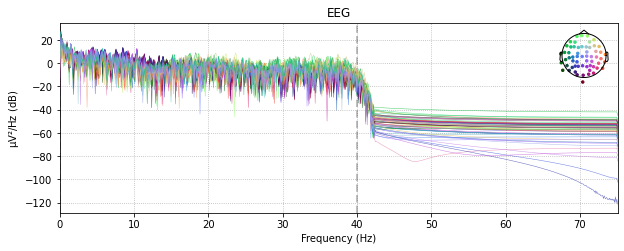

In [81]:
# Check filtering

# Visualize amplitudes at different frequencies

# Plotting the amplitudes (y-axis), for the different channels (color), over the different frequencies.
raw.plot_psd(area_mode='range', tmax=10.0, average=False) 

# Here it becomes apparent that there is a low-pass filter of roughly 40 -> amplitudes for frequencies above this are reduced greatly

Default filtering for the sample data is:
* highpass: 0.1 Hz
* lowpass: 40 Hz

You can see this by:
print(raw.info)

In [55]:
# Set up and fit the ICA (Independent Component Analysis)

# ICA -> Tries split data into X orthogonal components. The number of components is 20, here, but you can specify to do it until 95% of the variance is explained.
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800) # ica here is a model
ica.fit(raw) # fit data to model

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.9s.


<ICA | raw data decomposition, fit (fastica): 41700 samples, 20 components, channels used: "eeg">

# ICA - what does it do?
### - Across time and channels, it finds regular "components" -> Peaks/dips, such as the ones we see in evoked signals. (Could be peaks of eyeblinks, or regular peaks induced from events)
### - The components found are ordered by the amount of variance they explain (first component, most variance explained)
### - Eyeblinks and saccades induce large effects, and are often big explainers of variance (and thus are often some of the first components)
### - The components are the ones mapped below
### - We then exclude the components that maps saccades or eye-blinks (heavy activation near eyes)

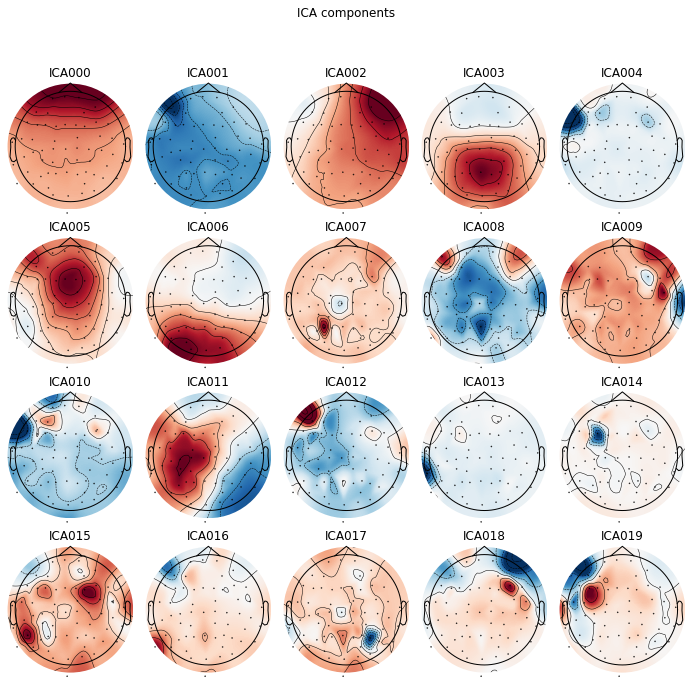

In [56]:
# To visualize the components, to eye-ball in order to know which components to exclude. This takes training
ica.plot_components();

Creating RawArray with float64 data, n_channels=20, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


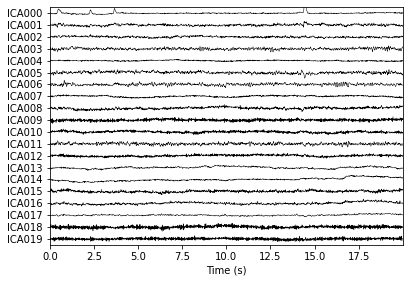

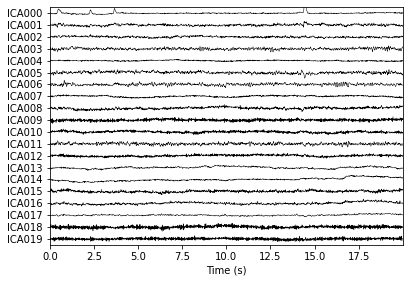

In [57]:
# To visualize the components, to eye-ball in order to know which components to exclude
ica.plot_sources(raw, show_scrollbars=False) # Plots time series of the ICA

In [58]:
# From eye-balling exclude bad components
ica.exclude = [0, 2]  # Exclude index 0 and index 2 (for this specific example)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


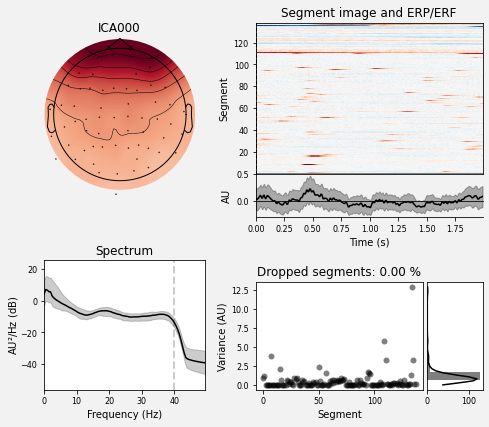

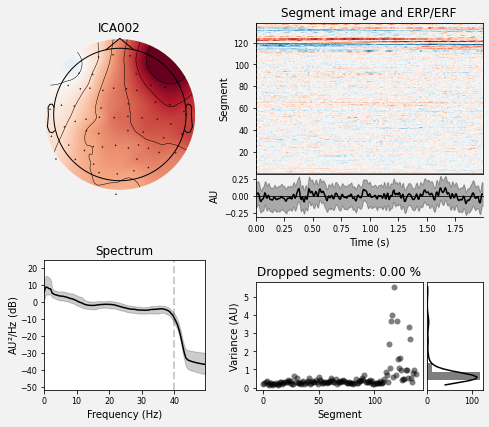

In [59]:
# Display component properties of the excluded (picks = ica.exclude)
ica.plot_properties(raw, picks=ica.exclude);

In [60]:
# Have the original data somewhere (here in "orig_raw")
orig_raw = raw.copy()

# Load it into memory (if it isn't already)
raw.load_data()

# Apply ICA to raw
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 59 PCA components


<Raw | sample_audvis_filt-0-40_raw.fif, 68 x 41700 (277.7 s), ~24.6 MB, data loaded>

There are many options with ICA, see
https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html
for a tutorial on ICA in MNE-python.

In [61]:
# Get channel names (to be able to see channels before and after ICA)
raw.info.ch_names

['STI 001',
 'STI 002',
 'STI 003',
 'STI 004',
 'STI 005',
 'STI 006',
 'STI 014',
 'STI 015',
 'STI 016',
 'EEG 001',
 'EEG 002',
 'EEG 003',
 'EEG 004',
 'EEG 005',
 'EEG 006',
 'EEG 007',
 'EEG 008',
 'EEG 009',
 'EEG 010',
 'EEG 011',
 'EEG 012',
 'EEG 013',
 'EEG 014',
 'EEG 015',
 'EEG 016',
 'EEG 017',
 'EEG 018',
 'EEG 019',
 'EEG 020',
 'EEG 021',
 'EEG 022',
 'EEG 023',
 'EEG 024',
 'EEG 025',
 'EEG 026',
 'EEG 027',
 'EEG 028',
 'EEG 029',
 'EEG 030',
 'EEG 031',
 'EEG 032',
 'EEG 033',
 'EEG 034',
 'EEG 035',
 'EEG 036',
 'EEG 037',
 'EEG 038',
 'EEG 039',
 'EEG 040',
 'EEG 041',
 'EEG 042',
 'EEG 043',
 'EEG 044',
 'EEG 045',
 'EEG 046',
 'EEG 047',
 'EEG 048',
 'EEG 049',
 'EEG 050',
 'EEG 051',
 'EEG 052',
 'EEG 054',
 'EEG 055',
 'EEG 056',
 'EEG 057',
 'EEG 058',
 'EEG 059',
 'EEG 060']

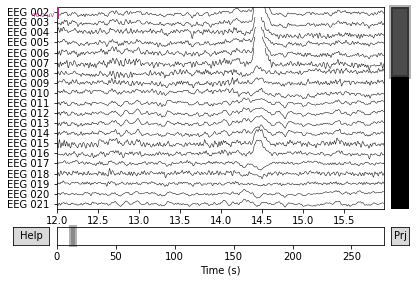

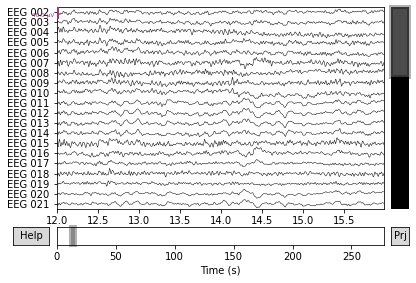

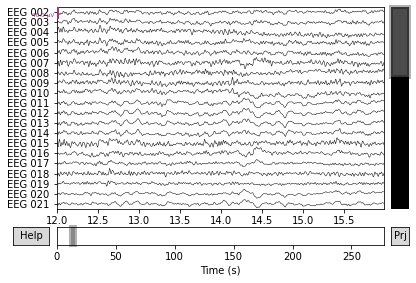

In [62]:
# Define list of channels to include in the plotting of channels before and after ICA
chs = raw.info.ch_names[10:]

# Get indexes from the names
chan_idxs = [raw.ch_names.index(ch) for ch in chs]

# Plot the original data prior to ICA
orig_raw.plot(order=chan_idxs, start=12, duration=4)

# Plot the data post ICA application
raw.plot(order=chan_idxs, start=12, duration=4)

# (the last plot is likely just the second one plotted again)

In [63]:
# Eye-glacing the stimulus (knowing at what time the event happened (1st column) and which type of event (3rd column))

events = mne.find_events(raw, stim_channel='STI 014') # You have to know the stim channel name. Here, for the Electra vector view it is: STI 014
print(events[:8])  # show the first 8

319 events found
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]
 [7506    0    3]
 [7612    0    1]
 [7709    0    4]]


In [64]:
# Get all unique event ID's
events = mne.find_events(raw)

319 events found
Event IDs: [ 1  2  3  4  5 32]


In [65]:
# Define a dictionary, that maps words with the unique event ID's
event_dict = {
'auditory/left': 1,
'auditory/right': 2, 
'visual/left': 3,
'visual/right': 4, 
'smiley': 5, 
'buttonpress': 32
}

In [66]:
# Have a list of conditions we are going to use
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']

In [76]:
# Specify which epoch signals to reject. If peak-to-peak signal amplitude is beyond reasonable limit for channel type. 
# The exact values are dependent on the paradigm you're working with
# mag=4000e-15,     # 4000 fT
# grad=4000e-13,    # 4000 fT/cm
# eeg=150e-6,       # 150 µV
# eog=250e-6       # 250 µV  # 150 µV

reject_criteria = dict(eeg=150e-6)


In [79]:
# Create epochs -> average signals of the raw data, for time windows define from events.
# Reject signals above/below threshold
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5,
                    reject=reject_criteria, preload=True)

Not setting metadata
Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 008']
1 bad epochs dropped


In [82]:
# Randomly sample epochs from each condition to match the number of epochs present in the condition with the fewest good epochs.
epochs.equalize_event_counts(conds_we_care_about)

# For this specific example, we want to pool all epochs that are auditory together (as with visual)
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']
del raw, epochs  # free up memory

Dropped 8 epochs: 0, 1, 14, 16, 18, 35, 101, 231


Not setting metadata
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


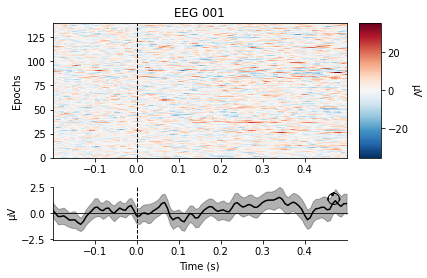

[<Figure size 432x288 with 4 Axes>]

In [88]:
# Visualize the epochs and evoked signals, for individual channels
aud_epochs.plot_image(picks=['EEG 001']) # You can add more channels in the list, to plot more than one channel

# What you see is for the single channel
# What you see in top part is the signal for each epoch
# What you see in bottom part is the averaged signal for all epochs

In [89]:
# For each channel, average across epochs, to get evoked signals (as seen in bottom of above plot)
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

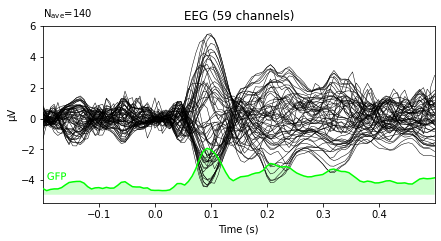

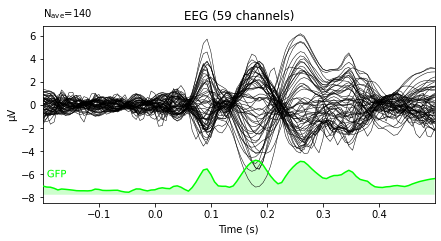

In [93]:
# Plot all evoked signals, and get GFP (SD of channel amplitudes at given time)
aud_evoked.plot(gfp=True);
vis_evoked.plot(gfp=True);

Projections have already been applied. Setting proj attribute to True.


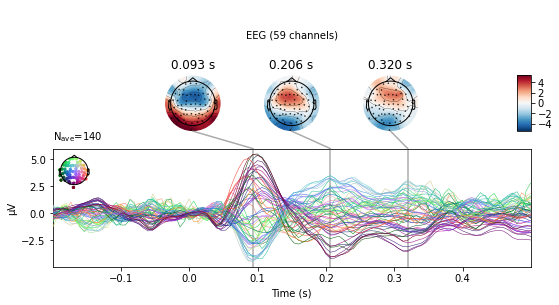

Projections have already been applied. Setting proj attribute to True.


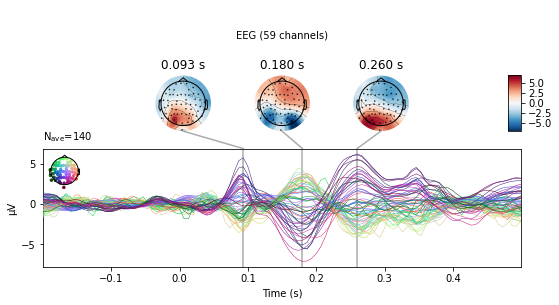

In [91]:
# Visualize evoked signals for all channels for an event/stimuli (for this example here we have two types of events; visual and auditory)
aud_evoked.plot_joint();
vis_evoked.plot_joint();

# Comparing evokeds

To visually comparing different evoked objects it is a good idea to calculate
 a _difference  wave_, i.e. one condition minus the other condition. In
 MNE-python ```mne.combine_evokeds```can do that.

combining channels using "gfp"
combining channels using "gfp"


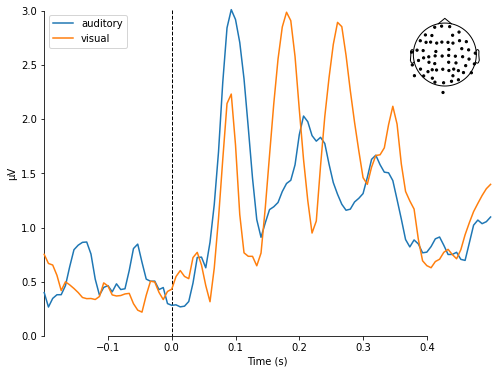

[<Figure size 576x432 with 2 Axes>]

In [94]:
mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right')

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


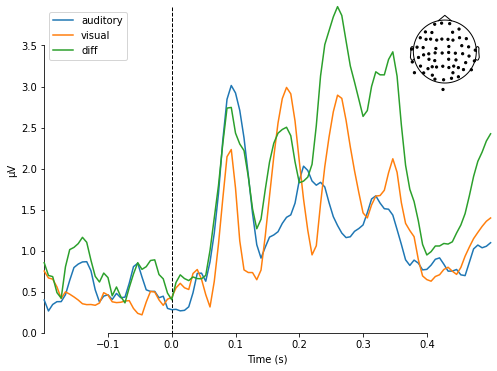

[<Figure size 576x432 with 2 Axes>]

In [98]:
# Calculate the difference between the evoked signals
difference_wave = mne.combine_evoked([vis_evoked, aud_evoked], weights=[1, -1])

# Plot the evoked signals between tasks, AND the difference
mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked, diff=difference_wave),
                             legend='upper left', show_sensors='upper right')

See also:
https://mne.tools/stable/generated/mne.viz.plot_compare_evokeds.html